In [1]:
import os, sys
import numpy as np
import torch
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
np.__version__

'1.17.4'

In [3]:
torch.__version__

'1.3.1'

Valid fold is specified [here](https://git.infra.melloddy.eu/wp2/melloddy-workflow-y1/-/blob/prod-testnet-v1/run-workflow.sh) :
```FOLD_TEST="0"
FOLD_VALIDATION="1"```

# Load data source used during testnet run using inflated dataset (manifest of July 3rd 2020) 


1. Download the splitted ChEMBL data from [here](https://app.box.com/folder/115927132115)
2. Identify your pharma partner ID from [here](https://az.app.box.com/file/665327503987) and use *partner<your_company_ID>.npy from Step 1 for inputs for the y, folding and weights
3. Download the testnet production run output in this [folder](https://app.box.com/folder/114759251715) (see dates) for your corresponding partner ID. E.g. here, [manifest of July 3rd, 2020](https://app.box.com/folder/117106580021). 



In [ ]:
# Load the Y matrix for partner 10 in order to verify the validation fold used
pharma_id = 10

y_true_all_file = f'data/pharma_11_partners_inflated/partner{pharma_id}/pharma_inflated_y_partner_{pharma_id}.npy'
y_true_all = np.load(y_true_all_file, allow_pickle=True).item().tocsr()


folds_file  =  f"data/pharma_11_partners_inflated/partner{pharma_id}/folding_inflated_partner_{pharma_id}.npy"
folds = np.load(folds_file, allow_pickle=True).astype(int)

# filter out valid fold = 1 and check out the shape
y_true_va1 = y_true_all[folds == 1]

print(f'Number of data points in the full source dataset : {y_true_all.nonzero()[0].shape[0]}')
print(f'Number of data points in the validatinon set     : {y_true_va1.nonzero()[0].shape[0]}')
print(f'Shape of the validation set labeled data         : {y_true_va1.shape}')

In [ ]:
# check Sizes of other folds
print(f'# data points fold 0 : {y_true_all[folds == 0].shape[0]}')
print(f'# data points fold 1 : {y_true_all[folds == 1].shape[0]}')
print(f'# data points fold 2 : {y_true_all[folds == 2].shape[0]}')
print(f'# data points fold 3 : {y_true_all[folds == 3].shape[0]}')
print(f'# data points fold 4 : {y_true_all[folds == 4].shape[0]}')

# Load the testnet predictions (sparse y_hat)

In [ ]:
# load the production testnet predictions (sparse y_hat)

# this file path has to be adjusted to the testnet run you for which you want to evaluate reproducibility:
testnet_yhat_file = "manifests_03-07-2020/output_model/var/substra/medias/subtuple/fe020e4cdc69bf166e2de6ddc55503f95d7dd4caa7f4e17fab3664aa38008dd0/pred/pred"
testnet_yhat = torch.load(testnet_yhat_file)

# get non zero elements (labeled data points in Y) in order to pick them in the dense y_hat of sparsechem obtained on-premises
nnz = testnet_yhat.nonzero()
testnet_yhat.shape, testnet_yhat.nonzero()[0].shape

# Produce predictions on premise with sparsechem (v 0.6.0)

### Sparse y_hat predictions with sparse-predict branch of sparsechem 

<b>Lower memory usage</b>: make sparse y_hat prediction for validation fold 1, with the [sparse-predict](https://git.infra.melloddy.eu/wp2/sparsechem/-/tree/sparse-predict) branch of sparsechem (as of July 14th, 2020).<br>

<br>
This approach yields into a y_hat.npy prediction file ~380M for inflated dataset of partner 10.<br>
The predictions take ~1h to get produced on CPU with 60G of memory.<br>
<br>


Command line call example to make <b>sparse</b> on premise predictions with sparsechem and pharma partner 10 inflated datas source (downloadable [here](https://app.box.com/folder/115927132115)) and the model exported from the [testnet run of July 3rd, 2020](https://app.box.com/folder/117106580021): <br>
```bash
python predict.py --x  data/pharma_11_partners_inflated/partner10/pharma_inflated_x_partner_10.npy
                  --y  data/pharma_11_partners_inflated/partner10/pharma_inflated_y_partner_10.npy
                  --folding data/pharma_11_partners_inflated/partner10/folding_inflated_partner_10.npy
                  --predict_fold 1
                  --conf manifests_03-07-2020/output_model/var/substra/medias/subtuple/fe020e4cdc69bf166e2de6ddc55503f95d7dd4caa7f4e17fab3664aa38008dd0/export/hyperparameters.json
                  --model manifests_03-07-2020/output_model/var/substra/medias/subtuple/fe020e4cdc69bf166e2de6ddc55503f95d7dd4caa7f4e17fab3664aa38008dd0/export/model.pth
                  --outfile pred_sparse_onpremise_manifest_03-07-2020_partner10_fva1.npy
                  --dev cpu
```

In [ ]:
# load local predictions (shape of the full Y matrix data source)
onpremise_sparse_yhat_va1 = np.load("pred_sparse_onpremise_manifest_03-07-2020_partner10_fva1.npy", allow_pickle=True).item() # 
nnz_onprem = onpremise_sparse_yhat_va1.nonzero()
onpremise_sparse_yhat_va1.shape, onpremise_sparse_yhat_va1.nonzero()[0].shape #=> should be same shape as fold_va 1 in Y data source

In [ ]:
# test if testnet predictions are close enough to on premise predictions: 
# with relative and absolute tolerances (rtol and atol) = 1e-5
# 
# Expected outcome if tesnet predictions are reproducible is "True" 
np.allclose(onpremise_sparse_yhat_va1[nnz_onprem], testnet_yhat[nnz], rtol=1e-05, atol=1e-05) # => Foir this manifest: True

---

# Load data source used during testnet run using chembl split dataset (manifest of June 25th, 2020) 


1. Download the splitted ChEMBL data from [here](https://az.app.box.com/file/665317784561)
2. Identify your pharma partner ID from [here](https://az.app.box.com/file/665327503987) and use *partner<your_company_ID>.npy from Step 1 for inputs for the y, folding and weights
3. Download the testnet production run output from a given manifest in this [folder](https://app.box.com/folder/114759251715) (see dates):  for your corresponding partner ID. E.g. here [manifest of June 25th, 2020](https://app.box.com/folder/116435387771)



In [ ]:
# Load the Y matrix for partner 9 in order to verify the validation fold used
pharma_id = 9

y_true_all_file = f'data/pharma_partners/pharma_y_partner_{pharma_id}.npy'
y_true_all = np.load(y_true_all_file, allow_pickle=True).item()


folds_file  =  f"data/pharma_partners/folding_partner_{pharma_id}.npy"
folds = np.load(folds_file, allow_pickle=True)

# filter out valid fold = 1 and check out the shape
y_true_va1 = y_true_all[folds == 1]

print(f'Number of data points in the full source dataset : {y_true_all.nonzero()[0].shape[0]}')
print(f'Number of data points in the validatinon set     : {y_true_va1.nonzero()[0].shape[0]}')
print(f'Shape of the validation set labeled data         : {y_true_va1.shape}')

In [ ]:
# check Sizes of other folds
print(f'# data points fold 0 : {y_true_all[folds == 0].shape[0]}')
print(f'# data points fold 1 : {y_true_all[folds == 1].shape[0]}')
print(f'# data points fold 2 : {y_true_all[folds == 2].shape[0]}')
print(f'# data points fold 3 : {y_true_all[folds == 3].shape[0]}')
print(f'# data points fold 4 : {y_true_all[folds == 4].shape[0]}')

In [ ]:
# this file path has to be adjusted to the testnet run you for which you want to evaluate reproducibility:
testnet_yhat_file = "manifests_25_06_2020/var/substra/medias/subtuple/f5aa781dd0c69e73073379907a9a3ca5b50b2ed8278a376bc7a5db988caf1b7b/pred/pred"
testnet_yhat = torch.load(testnet_yhat_file)

# get non zero elements (labeled data points in Y) in order to pick them in the dense y_hat of sparsechem obtained on-premises
nnz = testnet_yhat.nonzero()

testnet_yhat.shape #=> should be same shape as fold_va 1 in Y data source

### Dense y_hat predictions with sparsechem 

<br>Note</b>: dense predictions over the complete dataset require a considerable amount of memory (e.g. ~300Gb for inflated dataset of partner 10).<br>
Reducing the predictions to the validation set still requires a considerable amount of memory (e.g. 74Gb for the inflated dataset of partner 10). <br>

Command line call example to make on premise <b>dense</b> predictions with sparschem for pharma partner 9 data source X: <br>
```bash
# example call to produce dense predictins (for partner 9)
python predict.py --x data/pharma_partners/pharma_x_partner_9.npy \
                --conf manifests_25_06_2020/var/substra/medias/subtuple/f5aa781dd0c69e73073379907a9a3ca5b50b2ed8278a376bc7a5db988caf1b7b/export/hyperparameters.json \
                --model manifests_25_06_2020/var/substra/medias/subtuple/f5aa781dd0c69e73073379907a9a3ca5b50b2ed8278a376bc7a5db988caf1b7b/export/model.pth \
                --outfile pred_onpremise_manifest_25_06_2020_partner9.npy \
                --dev cpu
```

<br>

In [22]:
# now load on premises prediction made on the full data set pharma_x_partner_9.npy 
onpremise_yhat = np.load("pred_onpremise_manifest_25_06_2020_partner9.npy", allow_pickle=True)

# select only predictions over the validation fold 1 ( to match exported testnet predictions )
onpremise_yhat_va1 = onpremise_yhat[folds == 1]
print(f'Full prediction shape          : {onpremise_yhat.shape}')
print(f'Validation set prediction shape: {onpremise_yhat_va1.shape}') # => should match testnet_yhat.shape

Full prediction shape          : (197892, 322)
Validation set prediction shape: (38438, 322)


In [29]:
# test if testnet predictions are close enough to on premise predictions: 
# with relative and absolute tolerances (rtol and atol) = 1e-5
# 
# Expected outcome if tesnet predictions are reproducible is "True" 
np.allclose(onpremise_yhat_va1[nnz], testnet_yhat.toarray()[nnz], rtol=1e-05, atol=1e-05)

False

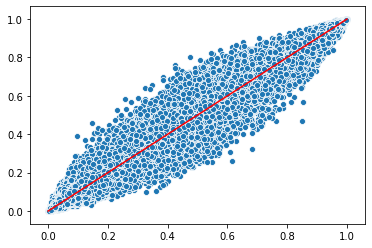

In [30]:
# checkout if on-premise predictions match the exported predictions
# ideally there should be a stragiht line on the diagonal with as small deviation as possible


#fig, ax = plt.subplots(figsize=(12, 7))
sns.scatterplot(x=onpremise_yhat_va1[nnz], y=testnet_yhat.toarray()[nnz])
ident = [0.0, 1.0]
plt.plot(ident,ident, color='r')

# the plot provided originally in this notebook shows "non-reproducible predictions"